### Importing the libraries

In [1]:
import tensorflow as tf

import os
import time
from datetime import datetime

import numpy as np 
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

### TensorFlow and Python version

In [2]:
print(str(tf.__version__))

2.1.0


In [3]:
import platform
print(platform.python_version())

3.7.6


### TensorFlow 2 Eager execution

Recall that in TensortFlow 2 eager execution is enabled by default. With eager execution operations are evaluated immediately without building graphs. Operations return concrete values instead of constructing a computational graph to run later.

In [4]:
tf.executing_eagerly()

True

### Loading the MNIST dataset

First we load the MNIST dataset directly from `tf.keras.datasets`. 

By printing the shape of `train_images` and `test_images` we see that we have 60000 training images and 10000 test images. Each MNIST picture consists of 28x28 pixels. 

In [5]:
train, test = tf.keras.datasets.mnist.load_data()
train_images, train_labels = train
test_images, test_labels = test

print("train_images shape: {}".format(train_images.shape))
print("test_images shape: {}".format(test_images.shape))

print()

print("train_labels shape: {}".format(train_labels.shape))
print("test_labels shape: {}".format(test_labels.shape))

train_images shape: (60000, 28, 28)
test_images shape: (10000, 28, 28)

train_labels shape: (60000,)
test_labels shape: (10000,)


### Reshaping and normalizing the dataset

In [6]:
# reshaping dataset
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype("float32")
test_images = test_images.reshape(test_images.shape[0],28,28,1).astype("float32")

# normalize dataset: each MNIST image consists of 28x28 integers between 0-255
train_images /= 255.
test_images /= 255.

# binarization: pixel values >= 0.5 become 1 | pixel values < 0.5 become 0
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.

test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.


### Shuffle dataset and create batches

**(Stochastic) Gradient Descent** works properly when the instances in the training set are **i.i.d**. An easy way to ensure this, is to shuffle the training data. We can do so by first creating a `TensorSliceDataset` object of `train_images` and `test_images` respectively and then applying the`shuffle()` method on them. 

We will also split our training and test data into **batches** by applying the `batch()` method.

For the sake of reproducibility we set `seed=42` in the method `shuffle()`.

In [7]:
# initialize varibles for shuffling dataset and creating batches
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

# shuffle dataset and creat batches
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF,seed=42).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF,seed=42).batch(BATCH_SIZE)

The last code cell shuffled our dataset and split it into batches of size `BATCH_SIZE`. When we iterate through **the first 3 items** in `train_dataset`, we see the shape of our batches is indeed what we wanted them to be.

In [8]:
for item in iter(train_dataset.take(3)):
    print(item.shape)

(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)


### How Variational Autoencoders work in a nutshell

### Network Architecture

### Refresher on Transposed Convolution
In case you are not familiar with **Transposed Convolution**, I recommend looking at these [visualizations](https://github.com/vdumoulin/conv_arithmetic) on github.

In [9]:
# define convolutional variational autoencoder model class
class CVAE(tf.keras.Model):
    def __init__(self,latent_dim):
        super(CVAE,self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28,28,1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2,2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2,2), activation='relu'),
                tf.keras.layers.Flatten(),
                # no activation since mean and log_var can be either pos. or neg.
                tf.keras.layers.Dense(latent_dim + latent_dim)

            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7,7,32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2,2),
                    padding="SAME",
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2,2),
                    padding="SAME",
                    activation='relu'),
                # no activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1,1), padding="SAME")

            ]
        )
    
    # here only decorate sample method with @tf.functionthe 
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(BATCH_SIZE, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    #methods below will be decorated with @tf.function in trainining loop
    def encode(self, x):
        mean, logvar =tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparametrize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar *.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

### The Loss Function

Variational Autoencoders are trained to maximize the evidence lower bound **(ELBO)** which is a lower bound to the marginal log likelihood, i.e. 

$\log p(x) \geq ELBO = \mathbb{E}_{q(z|x)}\bigg[\frac{p(x,z)}{q(z|x)}\bigg] = \mathbb{E}_{q(z|x)} \bigg[ \log p(x|z) + \log p(z) - \log q(z|x) \bigg]$.

We have to estimate the expectation above and will do this with a simple Monte Carlo estimate:

$\log p(x|z) + \log p(z) - \log q(z|x)$

where $z$ is sampled from $q(z|x)$.

**Note:**

The term 

$\mathbb{E}_{q(z|x)} \bigg[ \log p(z) - \log q(z|x) \bigg]$

is the **KL-Divergence** of two gaussians and has an analytic solution that we could use but for simplicity we will use a simple Monte Carlo estimate.

In [10]:
# use adam optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

# computes log of normal density
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample -mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )

# computes loss of model for batch x
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparametrize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# computes and applies gradients of loss with resoect to model weights
def get_compute_apply_gradients():
    @tf.function
    def compute_apply_gradients(model, x):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return compute_apply_gradients 

### Trainining
* We will train for **100 epochs**
* 

In [11]:
# hyperparameters of model and training
EPOCHS = 100
latent_dim = 50

# instantiate model
model = CVAE(latent_dim)

### Generating Images
Our model can generate **NEW IMAGES**. We would like to see what kind of images our model would generate after every epoch. We do this by:
* specifying the **numbers of examples** we want to generate in total at each epoch (in `num_examples_to_generate`)
* **sampling the latent vectors** form unit gaussian prior $p(z)$ (reference to these samples is `random_vector_for_generation`)
* after a certain epoch **feeding the generator** of the model each $z$ in `random_vector_for_generation`  and turn it into logits of $p(x|z)$ which is a Bernoulli Distribution on the pixels of an image
* **plotting the resulting Bernoulli distribution** $p(x|z)$ for each latent vecotr $z$

**Recall:** The Bernoulli distribution $=p(x|z)$ assigns each pixel $i$ a probabilty $\theta_i$ (the probabilty that the pixel is white). The expected image is  $\mathbb{E}_{p(x|z)}[ x ] = \theta$. We can thus see the expected image by plotting the generated probabilities $\theta$. The generator $p(x|z)$ outputs these probabilities $\theta$.

In [12]:
def generate_images(model, epoch, latent_vectors,path=None):
    predictions = model.sample(latent_vectors)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")
   
    if path:
        plt.savefig(os.path.join(path,"image_at_epoch_{:04d}.png".format(epoch)))
    
    plt.show()

In [13]:
def generate_image_directory():
    date = datetime.now() # datetime object containing current date and time
    date_string = date.strftime("d:%d-m:%m-%H:%M:%S")

    dirName = "trainingImages"
    path = os.path.join(dirName, date_string)

    os.makedirs(path)
    if os.path.exists(dirName):
        print("Directory with path {} is available to store training images.\n".format(path))
    else:    
        raise Exception("Directory for trainining images could not be created")
    
    return path

### Checkpoint for model weights

In [14]:
checkpoint_directory = "training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint=checkpoint,directory=checkpoint_directory,max_to_keep=3)

In [15]:
# initialize random latent vector for image generation (after training)
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate,latent_dim],seed=42)

In [16]:
EPOCHS = 300
steps_per_epoch = len(list(iter(train_dataset)))
latent_dim = 50

### Training

In [21]:
def train(loss_func, save_images=False, create_checkpoints=False, restore_model=False):
    # if save_images==True: create directory to save images
    if save_images==True:
        path = generate_image_directory()
    else:
        path = None
    
    # if restore_model==True: restore model weights
    if restore_model==True: 
        checkpoint.restore(manager.latest_checkpoint)
        if manager.latest_checkpoint:
            print("Restored Model from "
                  "{}\nContinue with training\n".format(manager.latest_checkpoint))
        else:
            raise Exception("Model could NOT be restored.\n")
    
    # generate images once before training
    generate_images(model, 0, random_vector_for_generation, path)
    
    # start training loop
    compute_apply_gradients = get_compute_apply_gradients()
    for epoch in range(1,EPOCHS+1):
        print("Epoch: {}".format(epoch))
        start_time = time.time()
        
        step = 1 
        for train_x in train_dataset:
            print("\rstep: {}/{}".format(step, steps_per_epoch),end="")
            compute_apply_gradients(model, train_x)
            step += 1
            
        end_time = time.time()
        
        if create_checkpoints == True:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        # print metrics and generate and save images
        if epoch % 1 == 0:
            loss = tf.keras.metrics.Mean()
            for test_x in test_dataset:
                loss(loss_func(model, test_x))
                
            elbo = -loss.result()
            display.clear_output(wait=False)
            print("Test set ELBO: {}\n"
                  "Time passed for current epoch: {}".format(elbo, end_time-start_time)
                 )
            generate_images(model, epoch, random_vector_for_generation, path)
        
        
            
        
        
        
        
        
        
        
    

Test set ELBO: -144.3441925048828
Time passed for current epoch: 31.371381998062134


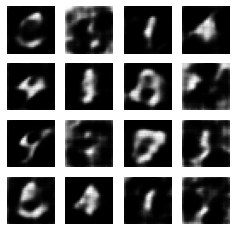

Epoch: 3
step: 432/600

KeyboardInterrupt: 

In [23]:
EPOCHS = 100
steps_per_epoch = len(list(iter(train_dataset)))
latent_dim = 50

optimizer = tf.keras.optimizers.Adam(1e-4)
model = CVAE(latent_dim)

train(loss_func=compute_loss,save_images=True, create_checkpoints=True,restore_model=False)